In [1]:
import requests as req
from bs4 import BeautifulSoup
import json
import math
import pandas as pd
import re
import numpy as np
import os
import random

In [2]:
def get_request_ug(url):
    '''Makes a get request to the specified Ultimate Guitar URL and returns relevant JSON data'''
    
    # Send request
    res = req.get(url)
    
    # Extract tab data from response
    # Note: I didn't bother with error handling in this instance, but you could check response code == 200, for example
    soup = BeautifulSoup(res.content) # format response content
    
    # Use BeautifulSoup to find relevant element, then cast to json and drill down the Ultimate-Guitar-Specific heirarchy
    page_data = json.loads(soup.find("div", {'class': 'js-store'})['data-content'])['store']['page']['data']
    
    return page_data

In [3]:
def scrape_page(page):
    # query params
    order = 'hitstotal_desc'  # order by total hits, descending order. i.e. most popular -> least popular
    tab_type = 'Chords'  # filter tabs that provide chord progression information (case sensitive)
    path = 'https://www.ultimate-guitar.com/explore'  # base endpoint path
    
    # generate url for request
    query_params = 'order=' + order + '&page=' + str(page)  + '&type[]=' + tab_type
    url = path + '?' + query_params
    
    # make request
    page_data = get_request_ug(url)['data']
    
    # create hits dataframe (stored separately to tab data)
    hits = page_data['hits']  # hits are stored with unique id which is also found in tab data
    hits = [[int(r['id']), int(r['hits'])] for r in hits]  # prep list of lists to be read into pandas dataframe, cast id and hits to integer to align with tabs dataset
    hits = pd.DataFrame(hits, columns = ['id', 'hits']).set_index('id')  # set index to shared unique id

    # create tabs dataframe (one page of data)
    tabs = page_data['tabs']  # extract all tabs and their attributes
    df = pd.DataFrame(tabs, columns=tabs[0].keys()).set_index('id')  # set index to shared unique id

    # join hits and tab data together for one page
    df = df.join(hits)  # adds hits dataframe to tabs dataframe - left join takes place by default on (shared) index
    return df

In [127]:
def get_tab_metadata(num_tabs):  
    #calc number of pages to scrape
    num_pages = math.ceil(num_tabs / 50)  # 50 tabs per page
    
    # initiate master dataframe
    df = pd.DataFrame()

    for p in range(1, num_pages + 1):
        page_tabs = scrape_page(p)
        df = df.append(page_tabs)
    return df

In [128]:
def get_chords(song_data):
    '''
    get_chords takes song data, and
    - extracts each of the following sections: Intro, Verse 1-9, Chorus, Outro, Bridge
    - parses each section for chords
    - returns 
        if tab in correct format: a dataframe with two columns [section, chords]
        otherwise: empty dataframe
    output columns
    - section: contains the name of each section eg. Chorus (may be duplicated)
    - chords: contians a list of chords eg. ['Eb', 'Gm6', 'Fsus4', 'Bb']
    '''
    
    # regex patterns
    extract_verse_name = r'\[[VCIOB][ehnur][roti][srd][euog][se ]?(\d?)\]'  # extract name of section. eg. Chorus
    extract_verse_with_name = extract_verse_name + r'\\r\\n(.*?)\\r\\n\\r\\n'  # extract each verse name and tab content
    extract_chords = r'\[ch\](.*?)\[\/ch\]'  # extract chords from within chord and lyric data
    
    song_data = song_data.replace('\r', '\\r').replace('\n', '\\n');  # to work with regex parser
    sections = re.finditer(extract_verse_with_name, song_data)  # has form [ '[section_name]', 'lyrics_and_chords' ]

    song = []  # intialise to hold data for each section
    for s in sections:
        section_string = song_data[s.start(): s.end()]  # extract a verse (with its name) from song_data
        section = re.search(extract_verse_name, section_string)  # get verse name from string
        
        section_name = section.group(0)[1:-1]  # remove []  surrounding section_name
        chords = re.findall(extract_chords, section_string)  # extract chords from lyrics
        section = {'section_name': section_name, 'chords': chords}  # save section name with its chords
        song.append(section)  # append to get a view for the whole song

    return pd.DataFrame(song)  # turn song into dataframe


In [129]:
# add HTML explaining chord nomenclature

In [178]:
def to_triad(chord):
    '''
    convert a chord into a three-note chord (triad)
    eg. A7sus4 -> A
    eg. E#dim7 -> E#dim
    '''
    dim = False  # indicates a diminished chord
    
    # systematically take everything above chord modifiers, from right to left
    # if the modifiers don't exist, then the chord is returned unchanged
    if '/' in chord:  # eg. A#m7/F -> A#m7
        chord = chord.split('/')[0]
    if 'sus' in chord: # eg. Csus2 -> C
        chord = chord.split('sus')[0]
    if 'add' in chord: # eg. Fmadd9 -> Fm
        chord = chord.split('add')[0]
    if 'maj' in chord:  # eg. Bbmaj7 -> Bb
        chord = chord.split('maj')[0]
    if 'dim' in chord:  # eg. A7dim -> A7
        chord = chord.split('dim')[0]
        dim = True  # flag for later, diminished chords are basic triads
        
    # at this point the chord is a simplified triad, except for the last position sometimes indicating
    # an extension on a triad chord (not a pure triad)
    if chord[-1].isnumeric():
        chord = chord[:-1]
    
    # append 'dim' modifier if applicable
    if dim:
        chord = chord + 'dim'
        
    return chord
   

def get_section_score(section, key_chords):
    '''
    returns number of matches between a sequence of chords and a set of chords
    '''
    return sum([1 for chord in section if chord in set(key_chords)])


def get_key(section):
    '''
    get_key takes a list of triad chords
    returns 
        keys: an array of possible keys
    multiple keys are possible where a section has limited chords \
    (eg. only 2 chords that are shared among multiple keys)
    '''

    scores = []
    for key in key_chord_mapping.columns:
        key_chords = key_chord_mapping[key]  # get chords corresponding to key
        score = get_section_score(section, key_chords)  # get match score for section chords against this key
        
        item = {'key': key, 'score': score}
        scores.append(item)
    key = max(scores, key=lambda x: x['score'])['key']
    
    return key


def guitar_to_piano_chords(chords, capo):
    '''
    takes a list of guitar chords and adjusts them to piano based on the fret that the capo is on (1 semitone per fret)
    returns
        pitched_up_chords: a list of chords raised by n=capo semitones
    '''
    
    chords_pitch_adj = []
    for chord in chords:
        for semitone in range(capo):
            chord = adjust_pitch_by_semitone(chord=chord, pitch_up=True)
        chords_pitch_adj.append(chord)
   
    return chords_pitch_adj
    
    
def is_flat(chord):
    if len(chord) > 1 and chord[1] == 'b':
        return True
    else:
        return False


def is_sharp(chord):
    if len(chord) > 1 and chord[1] == '#':
        return True
    else:
        return False


def is_minor(chord):
    if 'm' in chord and 'dim' not in chord:  # chord is minor
        return True
    else:
        return False
    

def is_dim(chord):
    if 'dim' in chord:
        return True
    else:
        return False

    
def adjust_pitch_by_semitone(chord, pitch_up):
    '''
    takes a chord and pitches_up based on value or pitch_up (boolean)
    returns
        pitch-adjusted chord
    '''
    
    minor = is_minor(chord)

    if minor:
        chord = chord[:-1]  # chop off m
    
    if pitch_up:
        switcher = {
            'A': 'A#',
            'A#': 'B',
            'Bb': 'B',
            'B': 'C',
            'Cb': 'C',
            'C': 'C#',
            'C#': 'D',
            'Db': 'D',
            'D': 'D#',
            'D#': 'E',
            'Eb': 'E',
            'E': 'F',
            'Fb': 'F',
            'F': 'F#',
            'F#': 'G',
            'Gb': 'G',
            'G': 'G#',
            'G#': 'A',
            'Ab': 'A',
        }
        
    elif not pitch_up:
        switcher = {
            'A#': 'A',
            'B': 'A#',
            'Cb': 'A#',
            'Bb': 'B',
            'C': 'B',
            'C#': 'C',
            'Db': 'C',
            'D': 'C#',
            'D#': 'D',
            'Eb': 'D',
            'E': 'D#',
            'Fb': 'D#',
            'F': 'E',
            'F#': 'F',
            'Gb': 'F',
            'G': 'F#',
            'G#': 'G',
            'Ab': 'G',
            'A': 'G#',
        }
        
    else:  # pitch_up not boolean, so return original chord
        return chord
    
    # get adjusted chord value
    chord = switcher.get(chord, None)

    if minor:
        chord = chord + 'm'  # add m back
    
    return chord


def chords_to_degree(chords, key, map_to_closest=False):
    '''
    chords_to_degree(chords, key)
    - maps chords in key provided scale degree (index of key_chord_mapping)
    '''
    chords_in_key = key_chord_mapping[key]
    chord_degrees = []
    for chord in chords:
        if chord in chords_in_key.to_list():
            degree = key_chord_mapping[chords_in_key==chord].index.to_numpy()[0]
        elif map_to_closest:
            chord = closest_chord_in_key(chord, key)
            degree = key_chord_mapping[chords_in_key==chord].index.to_numpy()[0]
        else:
            degree =  None
        chord_degrees.append(degree)
    
    return chord_degrees


def switch_notation(chord):
    """
    take a chord and switch to its equivalent notation 
    eg. A# -> Bb, Cb -> B, A#m -> G#m -> Abm
    if chord is not flat or sharp, pass through
    """
    
    minor = is_minor(chord)
    
    if minor:
        chord = chord[:-1]  # chop off m
        
    notation_switcher = {
        'A#': 'Bb',
        'D#': 'Eb',
        'G#': 'Ab',
        'C#': 'Db',
        'F#': 'Gb',
        'B': 'Cb',
        'Cb': 'B',
        'Gb': 'F#',
        'Db': 'C#',
        'Ab': 'G#',
        'Eb': 'D#',
        'Bb': 'A#'
    }
    
    chord = notation_switcher.get(chord, chord)

    if minor:
        chord = chord + 'm'
        
    return chord
    

def closest_chord_in_key(chord, key): 
    '''
    returning a close chord in key of the same chord quality (minor, major or diminished)
    '''
    
    chords_in_key = key_chord_mapping[key]

    if chord in chords_in_key:
        return chord
    elif is_dim(chord):  # chord degrees: 7
        # avoid while loop and retrieve correct diminised chord in key
        chord = chords_in_key[7]
        return chord
    else: # map to a closeby minor
        pitch_adj = [True, False]
        chords_in_key = chords_in_key.to_list()
        while chord not in chords_in_key and switch_notation(chord) not in chords_in_key:
            chord = adjust_pitch_by_semitone(chord=chord, pitch_up=random.choice(pitch_adj))

    if chord in chords_in_key:  # check whether sharp or flat representation was correct
        return chord
    else:
        return switch_notation(chord)

In [168]:
# User input
num_tabs = 100  # number of tabs wanted for dataset (will be rounded up to nearest 50 as tabs are scraped per page)

# End user input
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')
DATA_EXTERNAL_DIR = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
KEY_CHORD_MAPPING_DIR = os.path.join(DATA_DIR, 'lookups')
key_chord_mapping = pd.read_csv(os.path.join(KEY_CHORD_MAPPING_DIR, 'musical_key-triad_chord_mapping.csv'), index_col='Degree')

md = get_tab_metadata(num_tabs)  # scrape ultimate guitar 'explore' page for metadata (md)
md.drop(labels=['recording', 'part', 'tab_access_type', 'version_description', 'tp_version'], axis=1, inplace=True)

chords = []
# loop through tabs, fetch tab data and parse into chords
for index, tab_url in md['tab_url'].iteritems():  # get index to use as foreign key
    
    # send get request and extract tab info
    tab_data = get_request_ug(tab_url)['tab_view']  # get tab data
    tab_content = tab_data['wiki_tab']['content']  # extract tab content
    
    # extract capo fret number to pitch up guitar chords to get the true chord
    try: 
        # eg. capo on 2nd fret, a chord that is denoted as Em is actually F#m (E -> F -> F#)
        capo = tab_data['meta']['capo']
    except KeyError: 
        # capo key not present in json response
        capo = 0
        
    # parse tab content to extract chord
    song = get_chords(tab_content)
    
    # create additional columns, or move to next URL if song is empty
    if song.empty:
        continue
    else:  # list multiplication to create new column of correct length
        song['id'] = pd.Series([index] * len(song), dtype='int64')  # to be used to reference metadata (foreign key)
        song['capo'] = pd.Series([capo] * len(song), dtype='int64')  # save capo with chords
        song['key'] = pd.Series([None] * len(song), dtype='str')
        song['chords_simplified'] = pd.Series([None] * len(song), dtype='str')
        song['chords_simplified_pitch_corrected'] = pd.Series([None] * len(song), dtype='str')
        song['chords_numeric'] = pd.Series([None] * len(song), dtype='str')
    
    
    # get alternate chord representations
    song_chords = []
    for ids, section in song['chords'].iteritems():
        simple_section = []
        simple_pitch_corrected_section = []
        for chord in section:
            simple_chord = to_triad(chord)
            simple_section.append(simple_chord)
        
        # pitch correct guitar chords
        simple_pitch_corrected_section = guitar_to_piano_chords(simple_section, capo)
        
        # add alternate chords to dataframe
        song.at[ids, 'chords_simplified'] = simple_section
        song.at[ids, 'chords_simplified_pitch_corrected'] = simple_pitch_corrected_section
        
        song_chords.extend(simple_pitch_corrected_section)

    # get key of song - assumed 1 chord for entire song
    key = get_key(song_chords)
    
    # check if key (and chords) can be simplified
    key_changed = False
    if key in ['A#', 'D#', 'G#', 'C#', 'F#']:  # these keys can be represented more simply
        key = switch_notation(key)
        key_changed = True
    elif key in ['Cb']: # check separately to sharp keys to avoid needing to check if key is flat or sharp 
        key = switch_notation(key)
        key_changed = True
    
    if key_changed:  # update chords
        for ids, section in song['chords_simplified_pitch_corrected'].iteritems():
            sec = []
            for chord in section:
                sec.append(switch_notation(chord))
            song.at[ids, 'chords_simplified_pitch_corrected'] = sec
    # add song's key to each of its sections in the dataframe
    song['key'] = [key] * len(song)
    
    # loop through sections and make numeric
    for ids, section in song['chords_simplified_pitch_corrected'].iteritems():
        song.at[ids, 'chords_numeric'] = chords_to_degree(section, key, map_to_closest=True)
        
    # create chords: a list of song dataframes
    chords.append(pd.DataFrame(song))


F Db

F Db

F Db

F Db

F Db

C# D

C# D

C# D

B D

C# D

C# D

C# D

B D

C# B

D C

D C

D C

Fm C

D C

Fm C

D C

B C

Cm C

B C

Cm C

B C

Cm C

B C

Cm C

B C

Cm C

E C

E C

E C

E C

E C

E C

E C

E C

E C

D E

D E

D E

D E

D E

D E

D E

D E

D E

D E

D E

D E

B D

E D

B D

C#m D

B D

E D

F# E

F# E

B A

B A

B A

B A

B A

B A

B A

B A

B A

B A

B A

B A

B A

B A

Cm G

Cm G

F# D

E D

F# D

F# D

F# D

F# D

E D

F# D

F# D

F# D

F# D

E D

F# D

Db Eb

Db Eb

Db Eb

Db Eb

C Eb

Db Eb

Db Eb

Db Eb

Db Eb

C Eb

Db Eb

Db Eb

Db Eb

Db Eb

C Eb

C Eb

C Eb

G Eb

G Eb

C Eb

G Eb

G Eb

C Eb

G Eb

G Eb

C Eb

G Eb

G Eb

C Eb

C Eb

G#dim C

G#dim C

G#dim C

G#dim C

D C

E C

E C

E C

E C

E C

E C

E C

E C

E C

E C

E C

E C

D C

E C

E C

D C

E C

D C

E C

D C

E C

E C

D C

E C

D C

E C

D C

E C

E C

D C

E C

D C

E C

D C

E C

E C

D C

E C

D C

E C

D C

E C

E C

D C

E C

D C

E C

D C

E C

B A

B A

Abm Eb

Abm Eb

Abm Eb

Abm Eb


In [169]:
song.head()  # an individual song

,section_name,chords,id,capo,key,chords_simplified,chords_simplified_pitch_corrected,chords_numeric
0,Verse 1,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
1,Chorus,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
2,Verse 2,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
3,Chorus,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
4,Verse 3,"[D, A, Bm, G, D, A, Bm]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm]","[1, 5, 6, 4, 1, 5, 6]"


In [170]:
chords = pd.concat(chords, axis=0, ignore_index=True)
chords  # all songs concatenated

,section_name,chords,id,capo,key,chords_simplified,chords_simplified_pitch_corrected,chords_numeric
0,Intro,"[C, Am, C, Am]",198052,1,Db,"[C, Am, C, Am]","[Db, Bbm, Db, Bbm]","[1, 6, 1, 6]"
1,Verse 1,"[C, Am, C, Am, F, G, C, G, C, F, G, Am, F, G, ...",198052,1,Db,"[C, Am, C, Am, F, G, C, G, C, F, G, Am, F, G, ...","[Db, Bbm, Db, Bbm, Gb, Ab, Db, Ab, Db, Gb, Ab,...","[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]"
2,Chorus,"[F, Am, F, C, G, C, Am, C, Am]",198052,1,Db,"[F, Am, F, C, G, C, Am, C, Am]","[Gb, Bbm, Gb, Db, Ab, Db, Bbm, Db, Bbm]","[4, 6, 4, 1, 5, 1, 6, 1, 6]"
3,Verse 2,"[C, Am, C, Am, F, G, C, G, C, F, G, Am, F, G, ...",198052,1,Db,"[C, Am, C, Am, F, G, C, G, C, F, G, Am, F, G, ...","[Db, Bbm, Db, Bbm, Gb, Ab, Db, Ab, Db, Gb, Ab,...","[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]"
4,Chorus,"[F, Am, F, C, G, C, Am, C, Am]",198052,1,Db,"[F, Am, F, C, G, C, Am, C, Am]","[Gb, Bbm, Gb, Db, Ab, Db, Bbm, Db, Bbm]","[4, 6, 4, 1, 5, 1, 6, 1, 6]"
...,...,...,...,...,...,...,...,...
617,Verse 1,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
618,Chorus,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
619,Verse 2,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"
620,Chorus,"[D, A, Bm, G, D, A, Bm, G]",1148110,1,Eb,"[D, A, Bm, G, D, A, Bm, G]","[Eb, Bb, Cm, Ab, Eb, Bb, Cm, Ab]","[1, 5, 6, 4, 1, 5, 6, 4]"


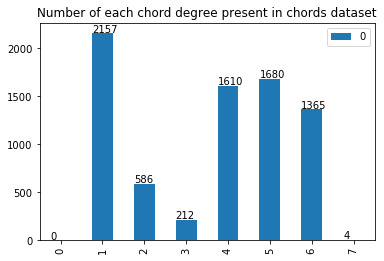

In [171]:
# sanity check

import matplotlib.pyplot as plt

x = np.zeros(8)

v = [1, 2, 3, 4, 5, 6, 7]  # valid chord degrees
for j in chords['chords_numeric']:
    for y in range(1, len(x)):
        x[y] = x[y] + sum([1 if z == y else 0 for z in j])
    x[0] = x[0] + sum([1 if z not in v else 0 for z in j])

x = pd.DataFrame(x)
x.plot.bar();
for i, j in enumerate(x[0]):
    plt.text(i - 0.25, j + 10, str(int(j)))
plt.title('Number of each chord degree present in chords dataset');
# all chords are represented with numbers 1-7
# there are no missed chords (represented by index 0)

In [172]:
key_chord_mapping

,A,A#,Bb,B,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab
Degree,,,,,,,,,,,,,,,,,
1,A,A#,Bb,B,C,C#,Db,D,D#,Eb,E,F,F#,Gb,G,G#,Ab
2,Bm,Cm,Cm,C#m,Dm,D#m,Ebm,Em,Fm,Fm,F#m,Gm,G#m,Abm,Am,A#m,Bbm
3,C#m,Dm,Dm,D#m,Em,Fm,Fm,F#m,Gm,Gm,G#m,Am,A#m,Bbm,Bm,Cm,Cm
4,D,D#,Eb,E,F,F#,Gb,G,G#,Ab,A,Bb,B,B,C,C#,Db
5,E,F,F,F#,G,G#,Ab,A,A#,Bb,B,C,C#,Db,D,D#,Eb
6,F#m,Gm,Gm,G#m,Am,A#m,Bbm,Bm,Cm,Cm,C#m,Dm,D#m,Ebm,Em,Fm,Fm
7,G#dim,Adim,Adim,A#dim,Bdim,Cdim,Cdim,C#dim,Ddim,Ddim,D#dim,Edim,Fdim,Fdim,F#dim,Gdim,Gdim


In [173]:
md.head()  # metadata (scraped from Explore page of Ultimate Guitar)

,song_id,song_name,artist_id,artist_name,type,version,votes,rating,date,status,preset_id,tonality_name,verified,artist_url,tab_url,type_name,hits
id,,,,,,,,,,,,,,,,,
198052,135952,Hallelujah,9898,Jeff Buckley,Chords,2,44798,4.87497,1121385600,approved,125,Db,0,https://www.ultimate-guitar.com/artist/jeff_bu...,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Chords,33628046
1956589,1710759,Perfect,30232,Ed Sheeran,Chords,1,36577,4.86007,1488453515,approved,18913,Ab,0,https://www.ultimate-guitar.com/artist/ed_shee...,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Chords,29561944
1248578,346275,All Of Me,11714,John Legend,Chords,1,22048,4.83845,1369872001,approved,14737,Em,0,https://www.ultimate-guitar.com/artist/john_le...,https://tabs.ultimate-guitar.com/tab/john-lege...,Chords,26729807
1137467,298037,Let Her Go,21762,Passenger,Chords,1,19691,4.85254,1331596801,approved,2333,Em,0,https://www.ultimate-guitar.com/artist/passeng...,https://tabs.ultimate-guitar.com/tab/passenger...,Chords,26610795
1086983,152656,Cant Help Falling In Love,11125,Elvis Presley,Chords,1,23769,4.86585,1314230401,approved,2368,C,0,https://www.ultimate-guitar.com/artist/elvis_p...,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Chords,23544487


In [174]:
md_columns = ['type', 'status', 'verified', 'type_name']
for c in md_columns:
    print(md[c].value_counts())

Chords    100
Name: type, dtype: int64
approved    100
Name: status, dtype: int64
0    100
Name: verified, dtype: int64
Chords    100
Name: type_name, dtype: int64


In [186]:
md = md.drop(md_columns, axis=1)
md = md.drop(['votes'], axis=1)
md.head()

KeyError: "['type' 'status' 'verified' 'type_name'] not found in axis"

In [177]:
md[md.index == chords['id'][0]]  # using id from song table to read from metadata df

,song_id,song_name,artist_id,artist_name,version,rating,date,preset_id,tonality_name,artist_url,tab_url,hits
id,,,,,,,,,,,,
198052,135952,Hallelujah,9898,Jeff Buckley,2,4.87497,1121385600,125,Db,https://www.ultimate-guitar.com/artist/jeff_bu...,https://tabs.ultimate-guitar.com/tab/jeff-buck...,33628046


In [ ]:
# investigate data, clean up and prep training and test datasets for ML

In [191]:
df = chords.join(md, on='id')

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 20 columns):
section_name                         622 non-null object
chords                               622 non-null object
id                                   622 non-null int64
capo                                 622 non-null int64
key                                  622 non-null object
chords_simplified                    622 non-null object
chords_simplified_pitch_corrected    622 non-null object
chords_numeric                       622 non-null object
song_id                              622 non-null int64
song_name                            622 non-null object
artist_id                            622 non-null int64
artist_name                          622 non-null object
version                              622 non-null int64
rating                               622 non-null float64
date                                 622 non-null object
preset_id                            622 non

In [193]:
df.isna().sum()

section_name                         0
chords                               0
id                                   0
capo                                 0
key                                  0
chords_simplified                    0
chords_simplified_pitch_corrected    0
chords_numeric                       0
song_id                              0
song_name                            0
artist_id                            0
artist_name                          0
version                              0
rating                               0
date                                 0
preset_id                            0
tonality_name                        0
artist_url                           0
tab_url                              0
hits                                 0
dtype: int64

In [202]:


##### TODO 
'''
select by song id
if unique id > 1:
    select the id of one  with highest hits
    drop others that dont have this id but have the same song_id


take slice
split into test and train
save chords to csv
save md to csv
save training data to csv
save test data to csv
'''

df[['id', 'song_id', 'version', 'section_name', 'song_name', 'artist_name', 'chords_numeric', 'hits']][df[['id', 'version', 'section_name', 'song_name', 'artist_name', 'chords_numeric', 'hits']]['song_name'] == 'Hallelujah']

,id,song_id,version,section_name,song_name,artist_name,chords_numeric,hits
0,198052,135952,2,Intro,Hallelujah,Jeff Buckley,"[1, 6, 1, 6]",33628046
1,198052,135952,2,Verse 1,Hallelujah,Jeff Buckley,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]",33628046
2,198052,135952,2,Chorus,Hallelujah,Jeff Buckley,"[4, 6, 4, 1, 5, 1, 6, 1, 6]",33628046
3,198052,135952,2,Verse 2,Hallelujah,Jeff Buckley,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]",33628046
4,198052,135952,2,Chorus,Hallelujah,Jeff Buckley,"[4, 6, 4, 1, 5, 1, 6, 1, 6]",33628046
5,198052,135952,2,Verse 3,Hallelujah,Jeff Buckley,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]",33628046
6,198052,135952,2,Chorus,Hallelujah,Jeff Buckley,"[4, 6, 4, 1, 5, 1, 6, 1, 6]",33628046
7,198052,135952,2,Verse 4,Hallelujah,Jeff Buckley,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]",33628046
8,198052,135952,2,Chorus,Hallelujah,Jeff Buckley,"[4, 6, 4, 1, 5, 1, 6, 1, 6]",33628046
9,198052,135952,2,Verse 5,Hallelujah,Jeff Buckley,"[1, 6, 1, 6, 4, 5, 1, 5, 1, 4, 5, 6, 4, 5, 4, 6]",33628046


In [201]:
x = 0
for i in df.chords_numeric:
    l = len(i)
    if l > x:
        x = l
print(x)

48


In [ ]:
#c.to_csv(os.path.join(DATA_PROCESSED_DIR, 'train', 'song_chords_by_section.csv'))